# Optimism Poison Hunter

Detect address poisoning attacks on the Optimism chain for USDC and USDT stablecoins.


## DATA PREP

### Option 1: Pull from BigQuery


In [3]:
# %%bigquery step_1_df
# SELECT 
#   block_hash,
#   block_number,
#   block_timestamp,
#   transaction_hash,
#   transaction_index,
#   log_index,
#   address,
#   data,
#   removed,
#   ARRAY_TO_STRING(topics, ',') AS topics_csv
# FROM `bigquery-public-data.goog_blockchain_optimism_mainnet_us.logs` 
# WHERE block_timestamp >= TIMESTAMP("2025-11-01")
#   AND block_timestamp < TIMESTAMP("2025-12-01")
# LIMIT 1000000


### Option 2: Load from CSV (optimism_txs.csv)


In [4]:
import pandas as pd
from tqdm.auto import tqdm

# Enable tqdm for pandas
tqdm.pandas()

# Load raw logs from CSV
print("Loading CSV file...")
raw_df = pd.read_csv('optimism_txs.csv')
print(f"Loaded {len(raw_df):,} raw log rows")

# Parse topics from comma-separated string
print("\nParsing topics...")
raw_df['topics'] = raw_df['topics_csv'].str.split(',')

# Filter for Transfer events only (topic[0] = Transfer signature)
# Handle NaN values by checking if x is a list first
print("Filtering for Transfer events...")
TRANSFER_SIGNATURE = '0xddf252ad1be2c89b69c2b068fc378daa952ba7f163c4a11628f55a4df523b3ef'
transfer_df = raw_df[raw_df['topics'].progress_apply(
    lambda x: isinstance(x, list) and len(x) >= 3 and x[0] == TRANSFER_SIGNATURE
)].copy()
print(f"Found {len(transfer_df):,} Transfer events")

# Filter for USDC and USDT tokens on Optimism
USDC_NATIVE = '0x0b2c639c533813f4aa9d7837caf62653d097ff85'
USDC_BRIDGED = '0x7f5c764cbc14f9669b88837ca1490cca17c31607'
USDT = '0x94b008aa00579c1307b0ef2c499ad98a8ce58e58'

transfer_df = transfer_df[transfer_df['address'].str.lower().isin([USDC_NATIVE, USDC_BRIDGED, USDT])].copy()
print(f"Filtered to {len(transfer_df):,} USDC/USDT transfers")

# Extract from_address and to_address from topics (last 40 chars of 32-byte hex)
print("\nExtracting addresses...")
transfer_df['from_address'] = transfer_df['topics'].progress_apply(lambda x: '0x' + x[1][-40:])
transfer_df['to_address'] = transfer_df['topics'].progress_apply(lambda x: '0x' + x[2][-40:])

# Convert hex data to numeric value
print("\nConverting values...")
transfer_df['value'] = transfer_df['data'].progress_apply(lambda x: int(x, 16) if pd.notna(x) and x != '0x' else 0)
transfer_df['value_usd'] = transfer_df['value'] / 1_000_000  # USDC/USDT have 6 decimals

# Rename address to token_address for consistency
transfer_df['token_address'] = transfer_df['address']

# Convert timestamp
transfer_df['block_timestamp'] = pd.to_datetime(transfer_df['block_timestamp'])

# Exclude self-transfers
transfer_df = transfer_df[transfer_df['from_address'] != transfer_df['to_address']]

# Select final columns
step_1_df = transfer_df[['block_number', 'block_timestamp', 'token_address', 
                          'from_address', 'to_address', 'value', 'value_usd', 
                          'transaction_hash']].copy()

# Sort by timestamp
step_1_df = step_1_df.sort_values('block_timestamp').reset_index(drop=True)

# Display basic info about the loaded data
print(f"\n{'='*50}")
print(f"Loaded {len(step_1_df):,} token transfer rows")
print(f"Date range: {step_1_df['block_timestamp'].min()} to {step_1_df['block_timestamp'].max()}")
print(f"Token addresses: {step_1_df['token_address'].unique()}")
step_1_df.head()


Loading CSV file...
Loaded 1,000,000 raw log rows

Parsing topics...
Filtering for Transfer events...


100%|██████████| 1000000/1000000 [00:00<00:00, 3364854.02it/s]


Found 189,034 Transfer events
Filtered to 54,004 USDC/USDT transfers

Extracting addresses...


100%|██████████| 54004/54004 [00:00<00:00, 2310257.47it/s]



Converting values...


100%|██████████| 54004/54004 [00:00<00:00, 1833191.92it/s]


Loaded 54,003 token transfer rows
Date range: 2025-11-01 04:07:51+00:00 to 2025-11-30 23:59:59+00:00
Token addresses: ['0x94b008aa00579c1307b0ef2c499ad98a8ce58e58'
 '0x0b2c639c533813f4aa9d7837caf62653d097ff85'
 '0x7f5c764cbc14f9669b88837ca1490cca17c31607']


,block_number,block_timestamp,token_address,from_address,to_address,value,value_usd,transaction_hash
0,143185647,2025-11-01 04:07:51+00:00,0x94b008aa00579c1307b0ef2c499ad98a8ce58e58,0x75983d5c139fa096b95a0d358082e90b014ce8b3,0xae51564961886aee70941d69a4f5968c96007200,1000000,1.000000,0x05aa748e71daac75452fe218301ae00f640400b9dd80...
1,143185647,2025-11-01 04:07:51+00:00,0x94b008aa00579c1307b0ef2c499ad98a8ce58e58,0xdd157c04a57213ccb2b7d5ec2236dd79ea8777cc,0xae51564961886aee70941d69a4f5968c96007200,1000000,1.000000,0x58a795f0d1f51d5c1c23158b7a36e1770c20bff1e734...
2,143185647,2025-11-01 04:07:51+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x80942a0066f72efff5900cf80c235dd32549b75d,0x707ba27189e8bf89e43b2198e6b88aac4720124f,524,0.000524,0x67add7456bec609c7b7bdf4562aa72f9cd3994e24263...
3,143185647,2025-11-01 04:07:51+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x707ba27189e8bf89e43b2198e6b88aac4720124f,0xfd259828bcd20715eb05a30394612403d5f4ce98,5,0.000005,0x67add7456bec609c7b7bdf4562aa72f9cd3994e24263...
4,143185647,2025-11-01 04:07:51+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,1052,0.001052,0x67add7456bec609c7b7bdf4562aa72f9cd3994e24263...


## Step 1: Block Filtering


In [5]:
import pandas as pd

min_block = step_1_df['block_number'].min()
max_block = step_1_df['block_number'].max()

def filter_by_block(start_block: int, end_block: int, df: pd.DataFrame = step_1_df) -> pd.DataFrame:
    """
    Filters a pandas DataFrame by block_number range and returns a new DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame containing a 'block_number' column.
        start_block (int): Minimum block_number (inclusive).
        end_block (int): Maximum block_number (inclusive).

    Returns:
        pd.DataFrame: Filtered DataFrame.
    """
    if 'block_number' not in df.columns:
        raise ValueError("DataFrame must contain a 'block_number' column.")
    
    filtered_df = df[(df['block_number'] >= start_block) & (df['block_number'] <= end_block)]
    return filtered_df

print(f"min block: {min_block}")
print(f"max block: {max_block}")
print(f"total blocks: {max_block - min_block + 1}")


min block: 143185647
max block: 144474211
total blocks: 1288565


## Step 2: Identify Suspicious Transactions (Zero-value and Dust Attacks)


In [6]:
import pandas as pd
import numpy as np
from typing import Set, Any

def step2_vectorized(window_dataframe, block_1):
    """
    Identify zero-value and dust attacks in a search window.
    
    Args:
        window_dataframe: DataFrame of transactions in the search window
        block_1: DataFrame of original victim transactions
    
    Returns:
        DataFrame of suspicious transactions with attacker/victim info
    """
    victim_set = set(block_1['from_address'])
    
    # Build victim -> tx_hashes mapping
    victim_to_tx_hashes = block_1.groupby('from_address')['transaction_hash'].apply(set).to_dict()
    
    # Vectorized conditions
    mask_zero = (window_dataframe['value_usd'] == 0) & (window_dataframe['from_address'].isin(victim_set))
    mask_dust = (window_dataframe['value_usd'] > 0) & (window_dataframe['value_usd'] <= 1) & (window_dataframe['to_address'].isin(victim_set))
    
    combined_mask = mask_zero | mask_dust
    
    # Early return if no matches
    if not combined_mask.any():
        return pd.DataFrame(columns=list(window_dataframe.columns) + ['attacker_address', 'victim_address', 'victim_tx_hash', 'attack_type'])
    
    # Filter matching rows
    suspicious_transactions = window_dataframe[combined_mask].copy()
    
    # Get the mask subset for proper alignment
    mask_zero_subset = mask_zero[combined_mask]
    
    # Set attacker address based on which condition matched
    suspicious_transactions['attacker_address'] = np.where(
        mask_zero_subset,
        suspicious_transactions['to_address'],
        suspicious_transactions['from_address']
    )
    
    # Set victim address (opposite of attacker)
    suspicious_transactions['victim_address'] = np.where(
        mask_zero_subset,
        suspicious_transactions['from_address'],
        suspicious_transactions['to_address']
    )
    
    # Set victim tx hash using the mapping
    suspicious_transactions['victim_tx_hash'] = suspicious_transactions['victim_address'].map(
        lambda addr: victim_to_tx_hashes.get(addr, set())
    )
    
    # Set attack type
    suspicious_transactions['attack_type'] = np.where(
        mask_zero_subset,
        'zero',
        'dust'
    )
    
    return suspicious_transactions

print("step2_vectorized function defined")


step2_vectorized function defined


### Step 2: Execute (Optimized Bulk Processing)


In [19]:
import numpy as np
import time
from tqdm.auto import tqdm

# Configuration
BLOCK_WINDOW = 600  # Search window size 20 minutes of blocks

# Process ALL blocks except the last BLOCK_WINDOW (needed for search window)
total_blocks = max_block - min_block + 1
NUM_BLOCKS = total_blocks - BLOCK_WINDOW
print(f"Total blocks in dataset: {total_blocks:,}")
print(f"Processing {NUM_BLOCKS:,} victim blocks (excluding last {BLOCK_WINDOW} for search window)")

start_time = time.time()

# Define block range
victim_blocks = np.arange(min_block, min_block + NUM_BLOCKS)

# Victim df = all transactions in those blocks
victim_df = step_1_df[step_1_df['block_number'].isin(victim_blocks)].copy()

# Window df = all transactions that could appear in any search window
search_min = min_block + 1
search_max = (min_block + NUM_BLOCKS - 1) + BLOCK_WINDOW + 1 

window_df = step_1_df[
    (step_1_df['block_number'] >= search_min) &
    (step_1_df['block_number'] <= search_max)
].copy()

# Build mapping: search_block → victim_block(s)
print("Building block mapping...")
search_unique_blocks = window_df['block_number'].unique()

mapping_rows = []
for b_s in tqdm(search_unique_blocks, desc="Mapping blocks"):
    v_low = b_s - BLOCK_WINDOW - 1
    v_high = b_s - 1
    valid_victims = victim_blocks[(victim_blocks >= v_low) & (victim_blocks <= v_high)]
    for v in valid_victims:
        mapping_rows.append((b_s, v))

block_map = pd.DataFrame(mapping_rows, columns=['search_block', 'victim_block'])

# Merge the mapping with window_df
window_df2 = window_df.merge(
    block_map,
    left_on='block_number',
    right_on='search_block',
    how='right'
).drop(columns=['search_block'])

# Group victims by block
victim_groups = {blk: grp for blk, grp in victim_df.groupby('block_number')}

# Run step2_vectorized in bulk
print("\nProcessing victim blocks...")
results = []
grouped = list(window_df2.groupby('victim_block'))
for v_block, win_grp in tqdm(grouped, desc="Scanning for attacks"):
    victim_block_df = victim_groups.get(v_block)
    if victim_block_df is None:
        continue
    out = step2_vectorized(win_grp, victim_block_df)
    if not out.empty:
        out['victim_block_number'] = v_block
        results.append(out)

# Combine results
step_2_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()

end_time = time.time()
print(f"\nStep 2 completed for {NUM_BLOCKS} blocks in {end_time - start_time:.2f} seconds")
print(f"Found {len(step_2_df)} suspicious transactions")


Total blocks in dataset: 1,288,565
Processing 1,287,965 victim blocks (excluding last 600 for search window)
Building block mapping...


Mapping blocks: 100%|██████████| 3584/3584 [00:01<00:00, 1972.92it/s]



Processing victim blocks...


Scanning for attacks: 100%|██████████| 15702/15702 [00:02<00:00, 5253.87it/s]


Step 2 completed for 1287965 blocks in 11.22 seconds
Found 1259842 suspicious transactions


## Step 3: Identify Lookalike Addresses


In [20]:
from typing import Tuple

def calculate_similarity_score(addr1: str, addr2: str) -> Tuple[int, int]:
    """
    Calculate prefix and suffix match length between two addresses.
    Case-insensitive comparison, ignores '0x' prefix.
    """
    addr1 = addr1.lower()
    addr2 = addr2.lower()
    
    if addr1.startswith('0x'):
        addr1 = addr1[2:]
    if addr2.startswith('0x'):
        addr2 = addr2[2:]
    
    # Calculate prefix match
    prefix_match = 0
    for c1, c2 in zip(addr1, addr2):
        if c1 == c2:
            prefix_match += 1
        else:
            break
    
    # Calculate suffix match
    suffix_match = 0
    for c1, c2 in zip(reversed(addr1), reversed(addr2)):
        if c1 == c2:
            suffix_match += 1
        else:
            break
    
    return prefix_match, suffix_match


def step3_extract_lookalikes_optimized(
    step2_df: pd.DataFrame,
    original_df: pd.DataFrame,
    min_prefix: int = 3,
    min_suffix: int = 4,
    show_progress: bool = True
) -> pd.DataFrame:
    """
    Extract lookalike addresses from step2 output.
    Uses victim_tx_hash from step2_df to find intended addresses from original transactions.
    """
    from tqdm.auto import tqdm
    
    new_columns = ['intended_address', 'prefix_match', 'suffix_match', 'attacker_transaction_hash', 'victim_transaction_hash', 'time_since_victim_tx', 'is_lookalike']
    
    if step2_df.empty:
        return pd.DataFrame(columns=list(step2_df.columns) + new_columns)
    
    # Build transaction_hash -> to_address mapping from original data
    tx_hash_to_recipient = original_df.set_index('transaction_hash')['to_address'].to_dict()
    
    # Build transaction_hash -> block_timestamp mapping for time delta calculation
    tx_hash_to_timestamp = original_df.set_index('transaction_hash')['block_timestamp'].to_dict()
    
    # Get unique (attacker, victim) pairs for efficient computation
    unique_pairs = step2_df[['attacker_address', 'victim_address', 'victim_tx_hash']].drop_duplicates(
        subset=['attacker_address', 'victim_address']
    )
    
    # Compute best matches for each unique pair
    results = []
    iterator = unique_pairs.iterrows()
    if show_progress:
        iterator = tqdm(list(iterator), desc="Analyzing lookalikes")
    
    for _, row in iterator:
        attacker = row['attacker_address']
        victim = row['victim_address']
        victim_tx_hashes = row['victim_tx_hash']
        
        # Get intended addresses from victim's transaction hashes
        intended_set = {tx_hash_to_recipient.get(tx_hash) for tx_hash in victim_tx_hashes if tx_hash in tx_hash_to_recipient}
        intended_set.discard(None)
        
        best_intended = None
        best_prefix = 0
        best_suffix = 0
        
        for intended in intended_set:
            p, s = calculate_similarity_score(attacker, intended)
            if (p + s) > (best_prefix + best_suffix):
                best_intended = intended
                best_prefix = p
                best_suffix = s
        
        # Find earliest victim transaction timestamp
        victim_timestamps = [tx_hash_to_timestamp.get(tx_hash) for tx_hash in victim_tx_hashes if tx_hash in tx_hash_to_timestamp]
        earliest_victim_ts = min(victim_timestamps) if victim_timestamps else None
        
        results.append({
            'attacker_address': attacker,
            'victim_address': victim,
            'intended_address': best_intended,
            'prefix_match': best_prefix,
            'suffix_match': best_suffix,
            'victim_timestamp': earliest_victim_ts
        })
    
    # Create lookup DataFrame and merge
    lookup_df = pd.DataFrame(results)
    result_df = step2_df.merge(lookup_df, on=['attacker_address', 'victim_address'], how='left')
    
    # Add transaction hash columns
    result_df['attacker_transaction_hash'] = result_df['transaction_hash']
    result_df['victim_transaction_hash'] = result_df['victim_tx_hash']
    
    # Calculate time since victim transaction (attack timestamp - victim timestamp)
    result_df['time_since_victim_tx'] = result_df['block_timestamp'] - result_df['victim_timestamp']
    
    # Add is_lookalike flag
    result_df['is_lookalike'] = (
        (result_df['prefix_match'] >= min_prefix) & 
        (result_df['suffix_match'] >= min_suffix)
    )
    
    return result_df

print("Step 3 functions defined")


Step 3 functions defined


### Step 3: Execute


In [21]:
# Run Step 3 - uses victim_tx_hash from step2_df to find intended addresses
step_3_df = step3_extract_lookalikes_optimized(
    step2_df=step_2_df,
    original_df=step_1_df,
    min_prefix=3,
    min_suffix=4
)

# Filter to confirmed attacks only
confirmed_attacks = step_3_df[step_3_df['is_lookalike'] == True]

print(f"Total suspicious transactions: {len(step_3_df)}")
print(f"Confirmed lookalike attacks: {len(confirmed_attacks)}")


Analyzing lookalikes: 100%|██████████| 2127/2127 [00:00<00:00, 306436.46it/s]


Total suspicious transactions: 1259842
Confirmed lookalike attacks: 226269


## Results


In [22]:
# View confirmed attacks
confirmed_attacks[['attacker_address', 'victim_address', 'intended_address', 
                   'prefix_match', 'suffix_match', 'attack_type', 
                   'attacker_transaction_hash', 'victim_transaction_hash']].head(20)


,attacker_address,victim_address,intended_address,prefix_match,suffix_match,attack_type,attacker_transaction_hash,victim_transaction_hash
1,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0x585a30534ecf933828c95cca3119883cc629de2320c2...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
5,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0x3430c2b048cbfe79b72fa5a5429c20ca9c511c5b3e72...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
14,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0x857dcf0c90aed87b614617678e17498e3cc9a6bb30f2...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
16,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0xbee29719976b83a08c45644158e80463439ac7fafea2...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
24,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0xbe01fdd0f32c97bdc62ebceb5858162bfbb2bbae2c10...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
25,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0xfe1765d3d006cf3b5f522b6e3662adf048f57917fcac...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
30,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0x798b680210d0517b372f01d6e963cb5dfebe0a81c648...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
37,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0x65b206d8312a206827de8843874aa15d8df218534899...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
42,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0xb07d1689cb5d1a13b559677aa2aa2d0933c513083f30...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...
45,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,0x80942a0066f72efff5900cf80c235dd32549b75d,0x36e3c209b373b861c185ecdbb8b2ebdd98587bdb,40,40,dust,0x4cae501843e901a4dde3088ff59cb461a42a5c887297...,{0x67add7456bec609c7b7bdf4562aa72f9cd3994e2426...


In [11]:
# Save results to CSV (optional)
# confirmed_attacks.to_csv('optimismData/optimism_confirmed_attacks.csv', index=False)
# step_3_df.to_csv('optimismData/optimism_all_suspicious.csv', index=False)
# print("Results saved to optimismData/")


## Step 4: Post Processing

Filter out false positives where the attacker address fully matches the intended address.


In [23]:
# Filter out instances where prefix_match or suffix_match is 40 (full address match = likely false positive)
# An Ethereum address has 40 hex characters (excluding '0x'), so 40 = complete match

before_count = len(confirmed_attacks)

# Keep only rows where NEITHER prefix_match NOR suffix_match equals 40
filtered_attacks = confirmed_attacks[
    (confirmed_attacks['prefix_match'] != 40) & 
    (confirmed_attacks['suffix_match'] != 40)
].copy()

after_count = len(filtered_attacks)

print(f"Before filtering: {before_count} confirmed attacks")
print(f"Removed: {before_count - after_count} rows with full address overlap (40 chars)")
print(f"After filtering: {after_count} confirmed attacks")

filtered_attacks


Before filtering: 226269 confirmed attacks
Removed: 225375 rows with full address overlap (40 chars)
After filtering: 894 confirmed attacks


,block_number,block_timestamp,token_address,from_address,to_address,value,value_usd,transaction_hash,victim_block,attacker_address,...,attack_type,victim_block_number,intended_address,prefix_match,suffix_match,victim_timestamp,attacker_transaction_hash,victim_transaction_hash,time_since_victim_tx,is_lookalike
21837,143185764,2025-11-01 04:11:45+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x957978e0f60c57f037769f55b2430a5d0e0edfe5,0x810b9a7eda9664e7ac35df6a8f1e1c033bd5afa2,0,0.000000,0xc6be31811abf10c84eeb752aea8ea4fcde795b5a7ffc...,143185657,0x810b9a7eda9664e7ac35df6a8f1e1c033bd5afa2,...,zero,143185657,0x810b928dba3123a8e3d3f9b2fbfba3d7ef95afa2,5,5,2025-11-01 04:08:11+00:00,0xc6be31811abf10c84eeb752aea8ea4fcde795b5a7ffc...,{0x0e61fbdf03f92b327ca9a7aca0ee69b29626389a5db...,0 days 00:03:34,True
21848,143185769,2025-11-01 04:11:55+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x810b9a7eda9664e7ac35df6a8f1e1c033bd5afa2,0x957978e0f60c57f037769f55b2430a5d0e0edfe5,230,0.000230,0x18d16b2d4c3ee4c74ebd4e9744b97eaf69abf531c709...,143185657,0x810b9a7eda9664e7ac35df6a8f1e1c033bd5afa2,...,dust,143185657,0x810b928dba3123a8e3d3f9b2fbfba3d7ef95afa2,5,5,2025-11-01 04:08:11+00:00,0x18d16b2d4c3ee4c74ebd4e9744b97eaf69abf531c709...,{0x0e61fbdf03f92b327ca9a7aca0ee69b29626389a5db...,0 days 00:03:44,True
21870,143185803,2025-11-01 04:13:03+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x957978e0f60c57f037769f55b2430a5d0e0edfe5,0x810bd3db3f8c1fe76e11d6c5c37d6fc90196afa2,0,0.000000,0x2e0d972d57b7ad1b6670e230c8980d02ae504a1f3252...,143185657,0x810bd3db3f8c1fe76e11d6c5c37d6fc90196afa2,...,zero,143185657,0x810b928dba3123a8e3d3f9b2fbfba3d7ef95afa2,4,4,2025-11-01 04:08:11+00:00,0x2e0d972d57b7ad1b6670e230c8980d02ae504a1f3252...,{0x0e61fbdf03f92b327ca9a7aca0ee69b29626389a5db...,0 days 00:04:52,True
22010,143185995,2025-11-01 04:19:27+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x957978e0f60c57f037769f55b2430a5d0e0edfe5,0x810bd3db3f8c1fe76e11d6c5c37d6fc90196afa2,0,0.000000,0x0a12fff846bace6771f2353e4e5200c13759bd240d30...,143185657,0x810bd3db3f8c1fe76e11d6c5c37d6fc90196afa2,...,zero,143185657,0x810b928dba3123a8e3d3f9b2fbfba3d7ef95afa2,4,4,2025-11-01 04:08:11+00:00,0x0a12fff846bace6771f2353e4e5200c13759bd240d30...,{0x0e61fbdf03f92b327ca9a7aca0ee69b29626389a5db...,0 days 00:11:16,True
22026,143186111,2025-11-01 04:23:19+00:00,0x0b2c639c533813f4aa9d7837caf62653d097ff85,0x957978e0f60c57f037769f55b2430a5d0e0edfe5,0x810bd3db3f8c1fe76e11d6c5c37d6fc90196afa2,0,0.000000,0x56b88a0aa0f650ea1049adbc434ad485ba1e8c1978dd...,143185657,0x810bd3db3f8c1fe76e11d6c5c37d6fc90196afa2,...,zero,143185657,0x810b928dba3123a8e3d3f9b2fbfba3d7ef95afa2,4,4,2025-11-01 04:08:11+00:00,0x56b88a0aa0f650ea1049adbc434ad485ba1e8c1978dd...,{0x0e61fbdf03f92b327ca9a7aca0ee69b29626389a5db...,0 days 00:15:08,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227638,144342758,2025-11-27 22:58:13+00:00,0x7f5c764cbc14f9669b88837ca1490cca17c31607,0xea363ec31b39370b8a467494282615b75f256880,0x65e0a6da94164e4c83f17d45dedd9ef94645fc23,0,0.000000,0xfbe91a92522de0b32b7f5b2d0f3a9ed8f7e1bc0abfe3...,144342740,0x65e0a6da94164e4c83f17d45dedd9ef94645fc23,...,zero,144342740,0x65e08e49abca9e3efdec03960d0671798329fc23,4,4,2025-11-27 22:57:37+00:00,0xfbe91a92522de0b32b7f5b2d0f3a9ed8f7e1bc0abfe3...,{0xbd4dc6b82a24d6560146fc8b8fef1797adf1f0e3565...,0 days 00:00:36,True
1228610,144474036,2025-11-30 23:54:09+00:00,0x94b008aa00579c1307b0ef2c499ad98a8ce58e58,0x3c4c19a8aee4c4b01c9c497d3177cdfabe91e8c7,0x948627f5c0352f320b284a2a9dbb92933866995d,562,0.000562,0x99077efed19af16cc506128b046f51cddf007819a81c...,144473588,0x3c4c19a8aee4c4b01c9c497d3177cdfabe91e8c7,...,dust,144473588,0x3c4c552ec8d9e8a2a8a1dc373d181e0dfc1be8c7,4,4,2025-11-27 03:44:01+00:00,0x99077efed19af16cc506128b046f51cddf007819a81c...,{0xb92dc173d4eb16b62812d624d5bd580a5752e96287a...,3 days 20:10:08,True
1241470,144473908,2025-11-30 23:49:53+00:00,0x94b008aa00579c1307b0ef2c499ad98a8ce58e58,0x94866b67a9a6a27231

## Step 5: Determine Successful Attacks

An attack is considered **successful** if the victim later sent a non-zero amount to the attacker's address (meaning they mistakenly copied the poisoned address instead of their intended recipient).


In [24]:
from tqdm.auto import tqdm

def find_successful_attacks(
    attacks_df: pd.DataFrame,
    all_transfers_df: pd.DataFrame,
    show_progress: bool = True
) -> pd.DataFrame:
    """
    Determine which attacks were successful by checking if the victim
    later sent a non-zero amount to the attacker's address.
    
    Args:
        attacks_df: DataFrame of confirmed attacks with attacker_address, victim_address, block_timestamp
        all_transfers_df: Original transaction DataFrame (step_1_df) to search for victim->attacker transfers
        show_progress: Whether to show progress bar
    
    Returns:
        DataFrame with additional columns: is_successful, success_tx_hash, success_value_usd, success_timestamp
    """
    if attacks_df.empty:
        attacks_df['is_successful'] = False
        attacks_df['success_tx_hash'] = None
        attacks_df['success_value_usd'] = None
        attacks_df['success_timestamp'] = None
        return attacks_df
    
    result_df = attacks_df.copy()
    
    # Initialize new columns
    result_df['is_successful'] = False
    result_df['success_tx_hash'] = None
    result_df['success_value_usd'] = None
    result_df['success_timestamp'] = None
    
    # Get unique (victim, attacker) pairs to avoid redundant searches
    unique_pairs = result_df[['victim_address', 'attacker_address']].drop_duplicates()
    
    # Build a lookup for victim->attacker transfers (non-zero value)
    # Filter all_transfers_df for potential success transactions
    potential_success = all_transfers_df[all_transfers_df['value_usd'] > 0].copy()
    
    # Create a mapping: (from_address, to_address) -> list of (tx_hash, value_usd, timestamp)
    success_lookup = {}
    
    iterator = unique_pairs.iterrows()
    if show_progress:
        iterator = tqdm(list(iterator), desc="Checking for successful attacks")
    
    for _, pair in iterator:
        victim = pair['victim_address']
        attacker = pair['attacker_address']
        
        # Find transfers where victim sent to attacker
        matches = potential_success[
            (potential_success['from_address'] == victim) & 
            (potential_success['to_address'] == attacker)
        ]
        
        if not matches.empty:
            # Get the first (or largest) successful transfer
            best_match = matches.loc[matches['value_usd'].idxmax()]
            success_lookup[(victim, attacker)] = {
                'tx_hash': best_match['transaction_hash'],
                'value_usd': best_match['value_usd'],
                'timestamp': best_match['block_timestamp']
            }
    
    # Apply the lookup to the result dataframe
    for idx, row in result_df.iterrows():
        key = (row['victim_address'], row['attacker_address'])
        if key in success_lookup:
            result_df.at[idx, 'is_successful'] = True
            result_df.at[idx, 'success_tx_hash'] = success_lookup[key]['tx_hash']
            result_df.at[idx, 'success_value_usd'] = success_lookup[key]['value_usd']
            result_df.at[idx, 'success_timestamp'] = success_lookup[key]['timestamp']
    
    return result_df

print("Step 5 function defined: find_successful_attacks()")


Step 5 function defined: find_successful_attacks()


### Step 5: Execute


In [25]:
# Run Step 5: Find successful attacks
step_5_df = find_successful_attacks(
    attacks_df=filtered_attacks,
    all_transfers_df=step_1_df,
    show_progress=True
)

# Get successful attacks
successful_attacks = step_5_df[step_5_df['is_successful'] == True]

# Summary statistics
print(f"\n{'='*50}")
print(f"Total confirmed attacks: {len(step_5_df)}")
print(f"Successful attacks: {len(successful_attacks)}")
print(f"Success rate: {len(successful_attacks)/len(step_5_df)*100:.2f}%" if len(step_5_df) > 0 else "N/A")

if len(successful_attacks) > 0:
    total_stolen = successful_attacks['success_value_usd'].sum()
    print(f"\nTotal value stolen: ${total_stolen:,.2f} USD")
    print(f"Average per successful attack: ${total_stolen/len(successful_attacks):,.2f} USD")


Checking for successful attacks: 100%|██████████| 688/688 [00:02<00:00, 327.88it/s]


Total confirmed attacks: 894
Successful attacks: 0
Success rate: 0.00%


In [15]:
# View successful attacks with key details
if len(successful_attacks) > 0:
    display_cols = ['victim_address', 'attacker_address', 'intended_address',
                    'attack_type', 'prefix_match', 'suffix_match',
                    'success_value_usd', 'success_tx_hash', 'success_timestamp']
    print("Successful attacks (victim sent funds to attacker):")
    display(successful_attacks[display_cols].sort_values('success_value_usd', ascending=False))
else:
    print("No successful attacks found in the dataset.")


No successful attacks found in the dataset.


## Step 6: Visualizations

Graphs showing the temporal distribution of attacks and successful attacks.


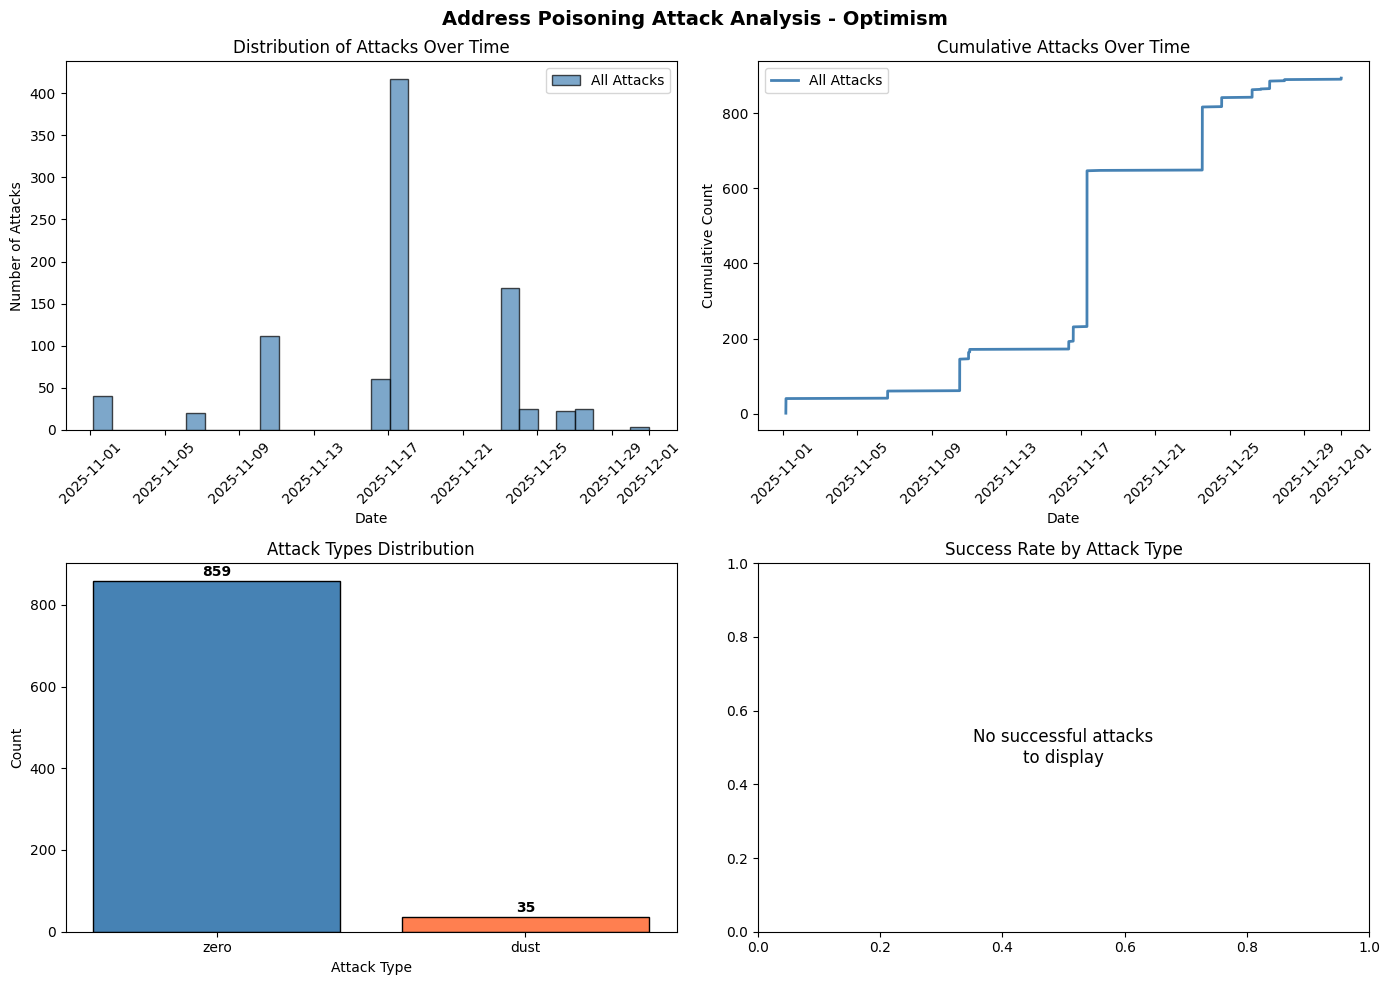

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set up the figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Address Poisoning Attack Analysis - Optimism', fontsize=14, fontweight='bold')

# --- Plot 1: Attacks over time (histogram) ---
ax1 = axes[0, 0]
if 'block_timestamp' in step_5_df.columns:
    ax1.hist(step_5_df['block_timestamp'], bins=30, color='steelblue', edgecolor='black', alpha=0.7, label='All Attacks')
    if len(successful_attacks) > 0:
        ax1.hist(successful_attacks['block_timestamp'], bins=30, color='red', edgecolor='black', alpha=0.7, label='Successful Attacks')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Attacks')
    ax1.set_title('Distribution of Attacks Over Time')
    ax1.legend()
    ax1.tick_params(axis='x', rotation=45)

# --- Plot 2: Cumulative attacks over time ---
ax2 = axes[0, 1]
if 'block_timestamp' in step_5_df.columns:
    sorted_attacks = step_5_df.sort_values('block_timestamp')
    sorted_attacks['cumulative'] = range(1, len(sorted_attacks) + 1)
    ax2.plot(sorted_attacks['block_timestamp'], sorted_attacks['cumulative'], 
             color='steelblue', linewidth=2, label='All Attacks')
    
    if len(successful_attacks) > 0:
        sorted_success = successful_attacks.sort_values('block_timestamp')
        sorted_success['cumulative'] = range(1, len(sorted_success) + 1)
        ax2.plot(sorted_success['block_timestamp'], sorted_success['cumulative'], 
                 color='red', linewidth=2, label='Successful Attacks')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Count')
    ax2.set_title('Cumulative Attacks Over Time')
    ax2.legend()
    ax2.tick_params(axis='x', rotation=45)

# --- Plot 3: Attack types breakdown ---
ax3 = axes[1, 0]
if 'attack_type' in step_5_df.columns:
    attack_types = step_5_df['attack_type'].value_counts()
    colors = ['steelblue', 'coral']
    bars = ax3.bar(attack_types.index, attack_types.values, color=colors[:len(attack_types)], edgecolor='black')
    ax3.set_xlabel('Attack Type')
    ax3.set_ylabel('Count')
    ax3.set_title('Attack Types Distribution')
    
    # Add value labels on bars
    for bar, val in zip(bars, attack_types.values):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                 str(val), ha='center', va='bottom', fontweight='bold')

# --- Plot 4: Success rate by attack type ---
ax4 = axes[1, 1]
if 'attack_type' in step_5_df.columns and len(successful_attacks) > 0:
    # Calculate success rate per attack type
    success_by_type = step_5_df.groupby('attack_type').agg(
        total=('is_successful', 'count'),
        successful=('is_successful', 'sum')
    )
    success_by_type['success_rate'] = (success_by_type['successful'] / success_by_type['total'] * 100)
    
    colors = ['steelblue', 'coral']
    bars = ax4.bar(success_by_type.index, success_by_type['success_rate'], 
                   color=colors[:len(success_by_type)], edgecolor='black')
    ax4.set_xlabel('Attack Type')
    ax4.set_ylabel('Success Rate (%)')
    ax4.set_title('Success Rate by Attack Type')
    ax4.set_ylim(0, 100)
    
    # Add value labels on bars
    for bar, val in zip(bars, success_by_type['success_rate']):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 f'{val:.1f}%', ha='center', va='bottom', fontweight='bold')
else:
    ax4.text(0.5, 0.5, 'No successful attacks\nto display', ha='center', va='center', 
             transform=ax4.transAxes, fontsize=12)
    ax4.set_title('Success Rate by Attack Type')

plt.tight_layout()
plt.show()


In [27]:
# Additional visualization: Value stolen over time (if there are successful attacks)
if len(successful_attacks) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Successful Attack Value Analysis - Optimism', fontsize=14, fontweight='bold')
    
    # --- Plot 1: Value stolen distribution ---
    ax1 = axes[0]
    ax1.hist(successful_attacks['success_value_usd'], bins=20, color='darkred', edgecolor='black', alpha=0.7)
    ax1.set_xlabel('Value Stolen (USD)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Distribution of Stolen Values')
    ax1.axvline(successful_attacks['success_value_usd'].median(), color='yellow', 
                linestyle='--', linewidth=2, label=f"Median: ${successful_attacks['success_value_usd'].median():,.2f}")
    ax1.legend()
    
    # --- Plot 2: Cumulative value stolen over time ---
    ax2 = axes[1]
    sorted_success = successful_attacks.sort_values('success_timestamp')
    sorted_success['cumulative_value'] = sorted_success['success_value_usd'].cumsum()
    ax2.fill_between(sorted_success['success_timestamp'], sorted_success['cumulative_value'], 
                     color='darkred', alpha=0.5)
    ax2.plot(sorted_success['success_timestamp'], sorted_success['cumulative_value'], 
             color='darkred', linewidth=2)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Cumulative Value Stolen (USD)')
    ax2.set_title('Cumulative Value Stolen Over Time')
    ax2.tick_params(axis='x', rotation=45)
    
    # Format y-axis as currency
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary stats
    print(f"\nValue Stolen Statistics:")
    print(f"  Min: ${successful_attacks['success_value_usd'].min():,.2f}")
    print(f"  Max: ${successful_attacks['success_value_usd'].max():,.2f}")
    print(f"  Mean: ${successful_attacks['success_value_usd'].mean():,.2f}")
    print(f"  Median: ${successful_attacks['success_value_usd'].median():,.2f}")
    print(f"  Total: ${successful_attacks['success_value_usd'].sum():,.2f}")
else:
    print("No successful attacks to visualize value data.")


No successful attacks to visualize value data.


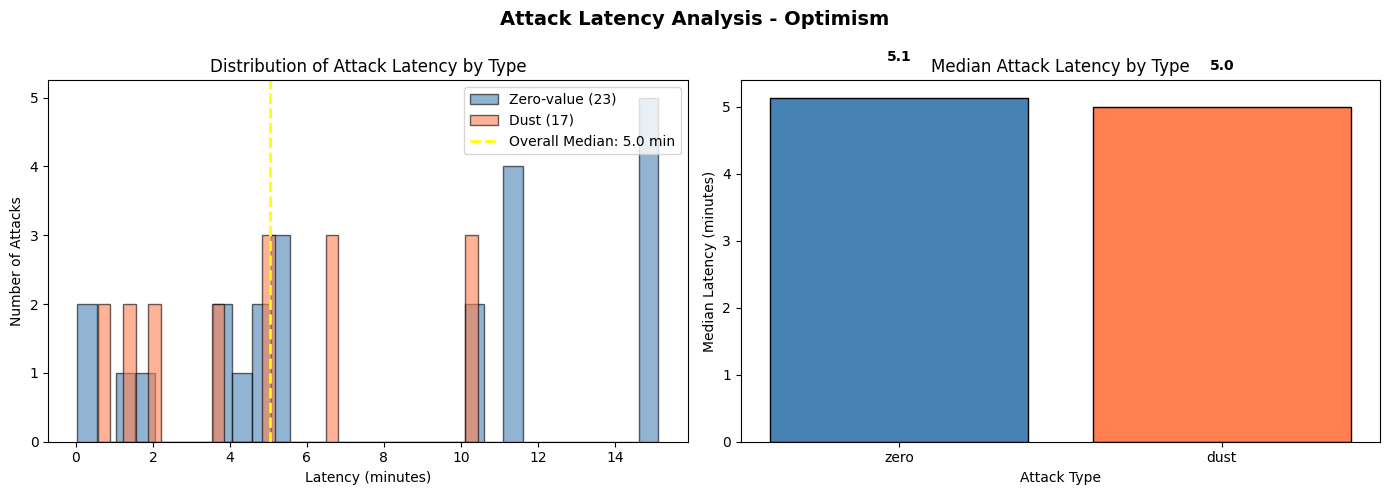


Attack Latency Statistics:
  Overall - Min: 0.03 min, Max: 15.13 min, Median: 5.05 min
  Zero - Min: 0.03 min, Max: 15.13 min, Median: 5.13 min, Count: 23
  Dust - Min: 0.57 min, Max: 10.43 min, Median: 5.00 min, Count: 17


In [18]:
# Attack Latency Analysis - Time between victim transaction and attack
if 'time_since_victim_tx' in step_5_df.columns:
    # Convert timedelta to seconds for plotting
    latency_data = step_5_df[step_5_df['time_since_victim_tx'].notna()].copy()
    latency_data['latency_seconds'] = latency_data['time_since_victim_tx'].dt.total_seconds()
    latency_data['latency_minutes'] = latency_data['latency_seconds'] / 60
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Attack Latency Analysis - Optimism', fontsize=14, fontweight='bold')
    
    # --- Plot 1: Distribution of attack latency by attack type ---
    ax1 = axes[0]
    if 'attack_type' in latency_data.columns:
        # Get data for each attack type
        zero_data = latency_data[latency_data['attack_type'] == 'zero']['latency_minutes']
        dust_data = latency_data[latency_data['attack_type'] == 'dust']['latency_minutes']
        
        # Plot overlapping histograms
        if len(zero_data) > 0:
            ax1.hist(zero_data, bins=30, color='steelblue', edgecolor='black', alpha=0.6, label=f'Zero-value ({len(zero_data)})')
        if len(dust_data) > 0:
            ax1.hist(dust_data, bins=30, color='coral', edgecolor='black', alpha=0.6, label=f'Dust ({len(dust_data)})')
        ax1.legend()
    else:
        ax1.hist(latency_data['latency_minutes'], bins=30, color='purple', edgecolor='black', alpha=0.7)
    
    ax1.set_xlabel('Latency (minutes)')
    ax1.set_ylabel('Number of Attacks')
    ax1.set_title('Distribution of Attack Latency by Type')
    
    # Add median line
    median_latency = latency_data['latency_minutes'].median()
    ax1.axvline(median_latency, color='yellow', linestyle='--', linewidth=2, 
                label=f'Overall Median: {median_latency:.1f} min')
    ax1.legend()
    
    # --- Plot 2: Latency by attack type (box plot for better distribution view) ---
    ax2 = axes[1]
    if 'attack_type' in latency_data.columns:
        attack_types = latency_data['attack_type'].unique()
        
        # Calculate statistics for each attack type
        stats = []
        for attack_type in attack_types:
            type_data = latency_data[latency_data['attack_type'] == attack_type]['latency_minutes']
            stats.append({
                'type': attack_type,
                'median': type_data.median(),
                'mean': type_data.mean(),
                'min': type_data.min(),
                'max': type_data.max()
            })
        
        stats_df = pd.DataFrame(stats)
        colors = ['steelblue', 'coral']
        bars = ax2.bar(stats_df['type'], stats_df['median'], color=colors[:len(stats_df)], edgecolor='black')
        ax2.set_xlabel('Attack Type')
        ax2.set_ylabel('Median Latency (minutes)')
        ax2.set_title('Median Attack Latency by Type')
        
        # Add value labels
        for bar, val in zip(bars, stats_df['median']):
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                     f'{val:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print latency statistics by attack type
    print(f"\nAttack Latency Statistics:")
    print(f"  Overall - Min: {latency_data['latency_minutes'].min():.2f} min, Max: {latency_data['latency_minutes'].max():.2f} min, Median: {latency_data['latency_minutes'].median():.2f} min")
    if 'attack_type' in latency_data.columns:
        for attack_type in latency_data['attack_type'].unique():
            type_data = latency_data[latency_data['attack_type'] == attack_type]['latency_minutes']
            print(f"  {attack_type.capitalize()} - Min: {type_data.min():.2f} min, Max: {type_data.max():.2f} min, Median: {type_data.median():.2f} min, Count: {len(type_data)}")
else:
    print("No latency data available. Make sure to run Step 3 with the updated function.")
